In [1]:
import dlc_practical_prologue as prologue

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
#Sometimes download directly will have http403 error
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load training and testing data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [5]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


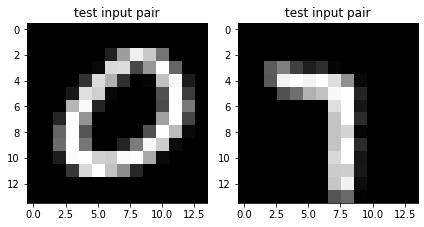

The test classes are: 0 and 7.
The test target is: 0


In [6]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [7]:
#weights_sharing_CNN
class CNN_Net_weight_sharing(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)

    def forward(self, x):
    
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        img1 = F.relu(F.max_pool2d(self.bn1(self.conv1(img1)), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.bn2(self.conv2(img1)), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.bn1(self.conv1(img2)), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.bn2(self.conv2(img2)), kernel_size=2, stride=2))
        output = torch.cat((img1.view(-1, 256),img2.view(-1, 256)),1)
        output = self.fc1(output)
        output = F.dropout(output,training=self.training)
        output = F.relu(output)
        output = self.fc2(output)
        
        
        return output

        # Training Function

    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
                loss = self.criterion(output, target)  
                self.optimizer.zero_grad()                           #set the weight and bias gradients to zero
                loss.backward()                                #backpropagation
                self.optimizer.step()
                # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
            
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [8]:
# build the mdoel instance
my_model=CNN_Net_weight_sharing()
# save the model
my_model.save_model('CNN_Net_weight_sharing.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 0.742217
Epoch: 001/025 | Batch 050/1000 | Loss: 1.178980
Epoch: 001/025 | Batch 100/1000 | Loss: 0.842297
Epoch: 001/025 | Batch 150/1000 | Loss: 0.854277
Epoch: 001/025 | Batch 200/1000 | Loss: 0.801010
Epoch: 001/025 | Batch 250/1000 | Loss: 0.850758
Epoch: 001/025 | Batch 300/1000 | Loss: 0.800134
Epoch: 001/025 | Batch 350/1000 | Loss: 0.604963
Epoch: 001/025 | Batch 400/1000 | Loss: 0.745970
Epoch: 001/025 | Batch 450/1000 | Loss: 0.598821
Epoch: 001/025 | Batch 500/1000 | Loss: 0.702526
Epoch: 001/025 | Batch 550/1000 | Loss: 0.732484
Epoch: 001/025 | Batch 600/1000 | Loss: 0.609378
Epoch: 001/025 | Batch 650/1000 | Loss: 0.698414
Epoch: 001/025 | Batch 700/1000 | Loss: 0.624692
Epoch: 001/025 | Batch 750/1000 | Loss: 0.628404
Epoch: 001/025 | Batch 800/1000 | Loss: 0.555365
Epoch: 001/025 | Batch 850/1000 | Loss: 0.592049
Epoch: 001/025 | Batch 900/1000 | Loss: 0.689480
Epoch: 001/025 | Batch 950/1000 | Loss: 0.534555
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 500/1000 | Loss: 0.446962
Epoch: 009/025 | Batch 550/1000 | Loss: 0.844304
Epoch: 009/025 | Batch 600/1000 | Loss: 0.368826
Epoch: 009/025 | Batch 650/1000 | Loss: 0.326538
Epoch: 009/025 | Batch 700/1000 | Loss: 0.237031
Epoch: 009/025 | Batch 750/1000 | Loss: 0.429275
Epoch: 009/025 | Batch 800/1000 | Loss: 0.501842
Epoch: 009/025 | Batch 850/1000 | Loss: 0.849117
Epoch: 009/025 | Batch 900/1000 | Loss: 0.243490
Epoch: 009/025 | Batch 950/1000 | Loss: 0.512139
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.360098
Epoch: 010/025 | Batch 050/1000 | Loss: 0.455695
Epoch: 010/025 | Batch 100/1000 | Loss: 0.349674
Epoch: 010/025 | Batch 150/1000 | Loss: 0.463221
Epoch: 010/025 | Batch 200/1000 | Loss: 0.360838
Epoch: 010/025 | Batch 250/1000 | Loss: 0.212671
Epoch: 010/025 | Batch 300/1000 | Loss: 0.380609
Epoch: 010/025 | Batch 350/1000 | Loss: 0.307671
Epoch: 010/025 | Batch 400/1000 | Loss: 0.456355
Epoch: 010/025 | Batch 450/1000 | Loss: 0.4841

Epoch: 018/025 | Batch 000/1000 | Loss: 0.168151
Epoch: 018/025 | Batch 050/1000 | Loss: 0.238826
Epoch: 018/025 | Batch 100/1000 | Loss: 0.197991
Epoch: 018/025 | Batch 150/1000 | Loss: 0.168337
Epoch: 018/025 | Batch 200/1000 | Loss: 0.214451
Epoch: 018/025 | Batch 250/1000 | Loss: 0.286920
Epoch: 018/025 | Batch 300/1000 | Loss: 0.243504
Epoch: 018/025 | Batch 350/1000 | Loss: 0.157467
Epoch: 018/025 | Batch 400/1000 | Loss: 0.127919
Epoch: 018/025 | Batch 450/1000 | Loss: 0.196174
Epoch: 018/025 | Batch 500/1000 | Loss: 0.180095
Epoch: 018/025 | Batch 550/1000 | Loss: 0.181097
Epoch: 018/025 | Batch 600/1000 | Loss: 0.237068
Epoch: 018/025 | Batch 650/1000 | Loss: 0.145245
Epoch: 018/025 | Batch 700/1000 | Loss: 0.154843
Epoch: 018/025 | Batch 750/1000 | Loss: 0.257491
Epoch: 018/025 | Batch 800/1000 | Loss: 0.130073
Epoch: 018/025 | Batch 850/1000 | Loss: 0.224195
Epoch: 018/025 | Batch 900/1000 | Loss: 0.204982
Epoch: 018/025 | Batch 950/1000 | Loss: 0.111527
Time elapsed: 0.21 m

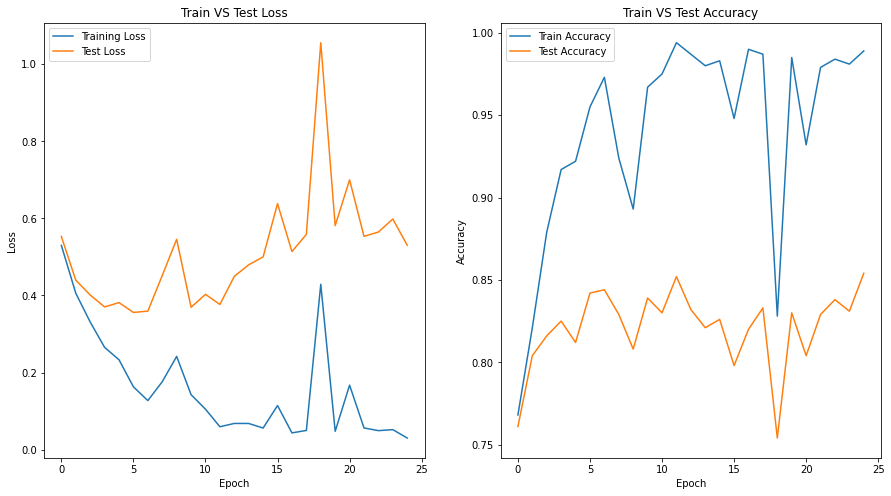

In [9]:
# train the model
my_model.trainer(train_input, train_target,test_input, test_target)

In [10]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 75202


Epoch: 001/025 | Batch 000/1000 | Loss: 0.700118
Epoch: 001/025 | Batch 050/1000 | Loss: 0.966086
Epoch: 001/025 | Batch 100/1000 | Loss: 0.711634
Epoch: 001/025 | Batch 150/1000 | Loss: 1.014736
Epoch: 001/025 | Batch 200/1000 | Loss: 0.753505
Epoch: 001/025 | Batch 250/1000 | Loss: 0.721027
Epoch: 001/025 | Batch 300/1000 | Loss: 0.936572
Epoch: 001/025 | Batch 350/1000 | Loss: 0.964847
Epoch: 001/025 | Batch 400/1000 | Loss: 0.614055
Epoch: 001/025 | Batch 450/1000 | Loss: 0.597152
Epoch: 001/025 | Batch 500/1000 | Loss: 0.688399
Epoch: 001/025 | Batch 550/1000 | Loss: 0.725096
Epoch: 001/025 | Batch 600/1000 | Loss: 0.688450
Epoch: 001/025 | Batch 650/1000 | Loss: 0.789061
Epoch: 001/025 | Batch 700/1000 | Loss: 0.624670
Epoch: 001/025 | Batch 750/1000 | Loss: 0.576275
Epoch: 001/025 | Batch 800/1000 | Loss: 0.623597
Epoch: 001/025 | Batch 850/1000 | Loss: 0.636125
Epoch: 001/025 | Batch 900/1000 | Loss: 0.647666
Epoch: 001/025 | Batch 950/1000 | Loss: 0.598716
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 500/1000 | Loss: 0.372867
Epoch: 009/025 | Batch 550/1000 | Loss: 0.275377
Epoch: 009/025 | Batch 600/1000 | Loss: 0.280169
Epoch: 009/025 | Batch 650/1000 | Loss: 0.179951
Epoch: 009/025 | Batch 700/1000 | Loss: 0.207912
Epoch: 009/025 | Batch 750/1000 | Loss: 0.242561
Epoch: 009/025 | Batch 800/1000 | Loss: 0.214663
Epoch: 009/025 | Batch 850/1000 | Loss: 0.267106
Epoch: 009/025 | Batch 900/1000 | Loss: 0.255170
Epoch: 009/025 | Batch 950/1000 | Loss: 0.311525
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.195144
Epoch: 010/025 | Batch 050/1000 | Loss: 0.333917
Epoch: 010/025 | Batch 100/1000 | Loss: 0.282173
Epoch: 010/025 | Batch 150/1000 | Loss: 0.171027
Epoch: 010/025 | Batch 200/1000 | Loss: 0.265938
Epoch: 010/025 | Batch 250/1000 | Loss: 0.342292
Epoch: 010/025 | Batch 300/1000 | Loss: 0.202143
Epoch: 010/025 | Batch 350/1000 | Loss: 0.194327
Epoch: 010/025 | Batch 400/1000 | Loss: 0.136893
Epoch: 010/025 | Batch 450/1000 | Loss: 0.4902

Epoch: 018/025 | Batch 000/1000 | Loss: 0.185580
Epoch: 018/025 | Batch 050/1000 | Loss: 0.173169
Epoch: 018/025 | Batch 100/1000 | Loss: 0.115782
Epoch: 018/025 | Batch 150/1000 | Loss: 0.145203
Epoch: 018/025 | Batch 200/1000 | Loss: 0.256891
Epoch: 018/025 | Batch 250/1000 | Loss: 0.303385
Epoch: 018/025 | Batch 300/1000 | Loss: 0.184204
Epoch: 018/025 | Batch 350/1000 | Loss: 0.205636
Epoch: 018/025 | Batch 400/1000 | Loss: 0.183501
Epoch: 018/025 | Batch 450/1000 | Loss: 0.261930
Epoch: 018/025 | Batch 500/1000 | Loss: 0.182062
Epoch: 018/025 | Batch 550/1000 | Loss: 0.115090
Epoch: 018/025 | Batch 600/1000 | Loss: 0.225871
Epoch: 018/025 | Batch 650/1000 | Loss: 0.159862
Epoch: 018/025 | Batch 700/1000 | Loss: 0.117850
Epoch: 018/025 | Batch 750/1000 | Loss: 0.172164
Epoch: 018/025 | Batch 800/1000 | Loss: 0.213051
Epoch: 018/025 | Batch 850/1000 | Loss: 0.107246
Epoch: 018/025 | Batch 900/1000 | Loss: 0.173841
Epoch: 018/025 | Batch 950/1000 | Loss: 0.191416
Time elapsed: 0.23 m

Epoch: 001/025 | Batch 500/1000 | Loss: 0.659525
Epoch: 001/025 | Batch 550/1000 | Loss: 0.706603
Epoch: 001/025 | Batch 600/1000 | Loss: 0.721533
Epoch: 001/025 | Batch 650/1000 | Loss: 0.666740
Epoch: 001/025 | Batch 700/1000 | Loss: 0.696215
Epoch: 001/025 | Batch 750/1000 | Loss: 0.656530
Epoch: 001/025 | Batch 800/1000 | Loss: 0.659341
Epoch: 001/025 | Batch 850/1000 | Loss: 0.650912
Epoch: 001/025 | Batch 900/1000 | Loss: 0.641347
Epoch: 001/025 | Batch 950/1000 | Loss: 0.716335
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 0.573787
Epoch: 002/025 | Batch 050/1000 | Loss: 0.614449
Epoch: 002/025 | Batch 100/1000 | Loss: 0.590766
Epoch: 002/025 | Batch 150/1000 | Loss: 0.655587
Epoch: 002/025 | Batch 200/1000 | Loss: 0.598666
Epoch: 002/025 | Batch 250/1000 | Loss: 0.608739
Epoch: 002/025 | Batch 300/1000 | Loss: 0.616875
Epoch: 002/025 | Batch 350/1000 | Loss: 0.609977
Epoch: 002/025 | Batch 400/1000 | Loss: 0.650343
Epoch: 002/025 | Batch 450/1000 | Loss: 0.6021

Epoch: 009/025 | Batch 900/1000 | Loss: 0.360202
Epoch: 009/025 | Batch 950/1000 | Loss: 0.299648
Time elapsed: 0.11 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.275481
Epoch: 010/025 | Batch 050/1000 | Loss: 0.402314
Epoch: 010/025 | Batch 100/1000 | Loss: 0.299594
Epoch: 010/025 | Batch 150/1000 | Loss: 0.280380
Epoch: 010/025 | Batch 200/1000 | Loss: 0.314861
Epoch: 010/025 | Batch 250/1000 | Loss: 0.239058
Epoch: 010/025 | Batch 300/1000 | Loss: 0.373957
Epoch: 010/025 | Batch 350/1000 | Loss: 0.265788
Epoch: 010/025 | Batch 400/1000 | Loss: 0.412030
Epoch: 010/025 | Batch 450/1000 | Loss: 0.283445
Epoch: 010/025 | Batch 500/1000 | Loss: 0.231735
Epoch: 010/025 | Batch 550/1000 | Loss: 0.352670
Epoch: 010/025 | Batch 600/1000 | Loss: 0.340431
Epoch: 010/025 | Batch 650/1000 | Loss: 0.329004
Epoch: 010/025 | Batch 700/1000 | Loss: 0.350105
Epoch: 010/025 | Batch 750/1000 | Loss: 0.264082
Epoch: 010/025 | Batch 800/1000 | Loss: 0.287561
Epoch: 010/025 | Batch 850/1000 | Loss: 0.3803

Epoch: 018/025 | Batch 500/1000 | Loss: 0.230063
Epoch: 018/025 | Batch 550/1000 | Loss: 0.324189
Epoch: 018/025 | Batch 600/1000 | Loss: 0.516736
Epoch: 018/025 | Batch 650/1000 | Loss: 0.278050
Epoch: 018/025 | Batch 700/1000 | Loss: 0.194876
Epoch: 018/025 | Batch 750/1000 | Loss: 0.258539
Epoch: 018/025 | Batch 800/1000 | Loss: 0.254488
Epoch: 018/025 | Batch 850/1000 | Loss: 0.331076
Epoch: 018/025 | Batch 900/1000 | Loss: 0.250979
Epoch: 018/025 | Batch 950/1000 | Loss: 0.202156
Time elapsed: 0.22 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.276277
Epoch: 019/025 | Batch 050/1000 | Loss: 0.577056
Epoch: 019/025 | Batch 100/1000 | Loss: 0.272187
Epoch: 019/025 | Batch 150/1000 | Loss: 0.369175
Epoch: 019/025 | Batch 200/1000 | Loss: 0.375009
Epoch: 019/025 | Batch 250/1000 | Loss: 0.216092
Epoch: 019/025 | Batch 300/1000 | Loss: 0.212919
Epoch: 019/025 | Batch 350/1000 | Loss: 0.144764
Epoch: 019/025 | Batch 400/1000 | Loss: 0.291016
Epoch: 019/025 | Batch 450/1000 | Loss: 0.2482

Epoch: 002/025 | Batch 000/1000 | Loss: 0.569621
Epoch: 002/025 | Batch 050/1000 | Loss: 0.543677
Epoch: 002/025 | Batch 100/1000 | Loss: 0.546665
Epoch: 002/025 | Batch 150/1000 | Loss: 0.529531
Epoch: 002/025 | Batch 200/1000 | Loss: 0.579582
Epoch: 002/025 | Batch 250/1000 | Loss: 0.513015
Epoch: 002/025 | Batch 300/1000 | Loss: 0.498660
Epoch: 002/025 | Batch 350/1000 | Loss: 0.528524
Epoch: 002/025 | Batch 400/1000 | Loss: 0.567589
Epoch: 002/025 | Batch 450/1000 | Loss: 0.574226
Epoch: 002/025 | Batch 500/1000 | Loss: 0.534975
Epoch: 002/025 | Batch 550/1000 | Loss: 0.508334
Epoch: 002/025 | Batch 600/1000 | Loss: 0.544131
Epoch: 002/025 | Batch 650/1000 | Loss: 0.533034
Epoch: 002/025 | Batch 700/1000 | Loss: 0.547655
Epoch: 002/025 | Batch 750/1000 | Loss: 0.436709
Epoch: 002/025 | Batch 800/1000 | Loss: 0.503046
Epoch: 002/025 | Batch 850/1000 | Loss: 0.473997
Epoch: 002/025 | Batch 900/1000 | Loss: 0.501520
Epoch: 002/025 | Batch 950/1000 | Loss: 0.443397
Time elapsed: 0.02 m

Epoch: 010/025 | Batch 500/1000 | Loss: 0.231911
Epoch: 010/025 | Batch 550/1000 | Loss: 0.262394
Epoch: 010/025 | Batch 600/1000 | Loss: 0.244978
Epoch: 010/025 | Batch 650/1000 | Loss: 0.232739
Epoch: 010/025 | Batch 700/1000 | Loss: 0.186639
Epoch: 010/025 | Batch 750/1000 | Loss: 0.241105
Epoch: 010/025 | Batch 800/1000 | Loss: 0.252325
Epoch: 010/025 | Batch 850/1000 | Loss: 0.191250
Epoch: 010/025 | Batch 900/1000 | Loss: 0.328030
Epoch: 010/025 | Batch 950/1000 | Loss: 0.255420
Time elapsed: 0.11 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.283665
Epoch: 011/025 | Batch 050/1000 | Loss: 0.170922
Epoch: 011/025 | Batch 100/1000 | Loss: 0.147029
Epoch: 011/025 | Batch 150/1000 | Loss: 0.250998
Epoch: 011/025 | Batch 200/1000 | Loss: 0.159721
Epoch: 011/025 | Batch 250/1000 | Loss: 0.329030
Epoch: 011/025 | Batch 300/1000 | Loss: 0.217253
Epoch: 011/025 | Batch 350/1000 | Loss: 0.269468
Epoch: 011/025 | Batch 400/1000 | Loss: 0.214080
Epoch: 011/025 | Batch 450/1000 | Loss: 0.1926

Epoch: 019/025 | Batch 000/1000 | Loss: 0.184595
Epoch: 019/025 | Batch 050/1000 | Loss: 0.113114
Epoch: 019/025 | Batch 100/1000 | Loss: 0.156556
Epoch: 019/025 | Batch 150/1000 | Loss: 0.239301
Epoch: 019/025 | Batch 200/1000 | Loss: 0.102131
Epoch: 019/025 | Batch 250/1000 | Loss: 0.241294
Epoch: 019/025 | Batch 300/1000 | Loss: 0.127848
Epoch: 019/025 | Batch 350/1000 | Loss: 0.154881
Epoch: 019/025 | Batch 400/1000 | Loss: 0.116949
Epoch: 019/025 | Batch 450/1000 | Loss: 0.141037
Epoch: 019/025 | Batch 500/1000 | Loss: 0.182058
Epoch: 019/025 | Batch 550/1000 | Loss: 0.113574
Epoch: 019/025 | Batch 600/1000 | Loss: 0.223081
Epoch: 019/025 | Batch 650/1000 | Loss: 0.188481
Epoch: 019/025 | Batch 700/1000 | Loss: 0.154979
Epoch: 019/025 | Batch 750/1000 | Loss: 0.197757
Epoch: 019/025 | Batch 800/1000 | Loss: 0.183508
Epoch: 019/025 | Batch 850/1000 | Loss: 0.182774
Epoch: 019/025 | Batch 900/1000 | Loss: 0.141262
Epoch: 019/025 | Batch 950/1000 | Loss: 0.183075
Time elapsed: 0.23 m

Epoch: 002/025 | Batch 500/1000 | Loss: 0.626390
Epoch: 002/025 | Batch 550/1000 | Loss: 0.610803
Epoch: 002/025 | Batch 600/1000 | Loss: 0.575373
Epoch: 002/025 | Batch 650/1000 | Loss: 0.586378
Epoch: 002/025 | Batch 700/1000 | Loss: 0.596220
Epoch: 002/025 | Batch 750/1000 | Loss: 0.637538
Epoch: 002/025 | Batch 800/1000 | Loss: 0.560532
Epoch: 002/025 | Batch 850/1000 | Loss: 0.575843
Epoch: 002/025 | Batch 900/1000 | Loss: 0.565661
Epoch: 002/025 | Batch 950/1000 | Loss: 0.603971
Time elapsed: 0.02 min
Epoch: 003/025 | Batch 000/1000 | Loss: 0.525848
Epoch: 003/025 | Batch 050/1000 | Loss: 0.452458
Epoch: 003/025 | Batch 100/1000 | Loss: 0.562107
Epoch: 003/025 | Batch 150/1000 | Loss: 0.611327
Epoch: 003/025 | Batch 200/1000 | Loss: 0.673352
Epoch: 003/025 | Batch 250/1000 | Loss: 0.632129
Epoch: 003/025 | Batch 300/1000 | Loss: 0.540859
Epoch: 003/025 | Batch 350/1000 | Loss: 0.515658
Epoch: 003/025 | Batch 400/1000 | Loss: 0.598439
Epoch: 003/025 | Batch 450/1000 | Loss: 0.4571

Epoch: 010/025 | Batch 950/1000 | Loss: 0.179692
Time elapsed: 0.13 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.313783
Epoch: 011/025 | Batch 050/1000 | Loss: 0.226033
Epoch: 011/025 | Batch 100/1000 | Loss: 0.280106
Epoch: 011/025 | Batch 150/1000 | Loss: 0.366505
Epoch: 011/025 | Batch 200/1000 | Loss: 0.255280
Epoch: 011/025 | Batch 250/1000 | Loss: 0.219964
Epoch: 011/025 | Batch 300/1000 | Loss: 0.282615
Epoch: 011/025 | Batch 350/1000 | Loss: 0.249154
Epoch: 011/025 | Batch 400/1000 | Loss: 0.313654
Epoch: 011/025 | Batch 450/1000 | Loss: 0.259545
Epoch: 011/025 | Batch 500/1000 | Loss: 0.253143
Epoch: 011/025 | Batch 550/1000 | Loss: 0.151377
Epoch: 011/025 | Batch 600/1000 | Loss: 0.311492
Epoch: 011/025 | Batch 650/1000 | Loss: 0.276937
Epoch: 011/025 | Batch 700/1000 | Loss: 0.256314
Epoch: 011/025 | Batch 750/1000 | Loss: 0.226162
Epoch: 011/025 | Batch 800/1000 | Loss: 0.193101
Epoch: 011/025 | Batch 850/1000 | Loss: 0.153033
Epoch: 011/025 | Batch 900/1000 | Loss: 0.2300

Epoch: 019/025 | Batch 450/1000 | Loss: 0.374220
Epoch: 019/025 | Batch 500/1000 | Loss: 0.206923
Epoch: 019/025 | Batch 550/1000 | Loss: 0.163707
Epoch: 019/025 | Batch 600/1000 | Loss: 0.242213
Epoch: 019/025 | Batch 650/1000 | Loss: 0.228111
Epoch: 019/025 | Batch 700/1000 | Loss: 0.251854
Epoch: 019/025 | Batch 750/1000 | Loss: 0.208330
Epoch: 019/025 | Batch 800/1000 | Loss: 0.319473
Epoch: 019/025 | Batch 850/1000 | Loss: 0.260093
Epoch: 019/025 | Batch 900/1000 | Loss: 0.247667
Epoch: 019/025 | Batch 950/1000 | Loss: 0.299830
Time elapsed: 0.25 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.256190
Epoch: 020/025 | Batch 050/1000 | Loss: 0.248631
Epoch: 020/025 | Batch 100/1000 | Loss: 0.271076
Epoch: 020/025 | Batch 150/1000 | Loss: 0.297600
Epoch: 020/025 | Batch 200/1000 | Loss: 0.280968
Epoch: 020/025 | Batch 250/1000 | Loss: 0.171402
Epoch: 020/025 | Batch 300/1000 | Loss: 0.268829
Epoch: 020/025 | Batch 350/1000 | Loss: 0.292091
Epoch: 020/025 | Batch 400/1000 | Loss: 0.2913

Epoch: 002/025 | Batch 900/1000 | Loss: 0.532736
Epoch: 002/025 | Batch 950/1000 | Loss: 0.400399
Time elapsed: 0.02 min
Epoch: 003/025 | Batch 000/1000 | Loss: 0.640469
Epoch: 003/025 | Batch 050/1000 | Loss: 0.326133
Epoch: 003/025 | Batch 100/1000 | Loss: 0.375905
Epoch: 003/025 | Batch 150/1000 | Loss: 0.465498
Epoch: 003/025 | Batch 200/1000 | Loss: 0.440093
Epoch: 003/025 | Batch 250/1000 | Loss: 0.478850
Epoch: 003/025 | Batch 300/1000 | Loss: 0.459803
Epoch: 003/025 | Batch 350/1000 | Loss: 0.384471
Epoch: 003/025 | Batch 400/1000 | Loss: 0.588103
Epoch: 003/025 | Batch 450/1000 | Loss: 0.666095
Epoch: 003/025 | Batch 500/1000 | Loss: 0.562825
Epoch: 003/025 | Batch 550/1000 | Loss: 0.414712
Epoch: 003/025 | Batch 600/1000 | Loss: 0.630450
Epoch: 003/025 | Batch 650/1000 | Loss: 0.540383
Epoch: 003/025 | Batch 700/1000 | Loss: 0.545801
Epoch: 003/025 | Batch 750/1000 | Loss: 0.448480
Epoch: 003/025 | Batch 800/1000 | Loss: 0.495740
Epoch: 003/025 | Batch 850/1000 | Loss: 0.4245

Epoch: 011/025 | Batch 450/1000 | Loss: 0.205312
Epoch: 011/025 | Batch 500/1000 | Loss: 0.154823
Epoch: 011/025 | Batch 550/1000 | Loss: 0.255429
Epoch: 011/025 | Batch 600/1000 | Loss: 0.247617
Epoch: 011/025 | Batch 650/1000 | Loss: 0.212994
Epoch: 011/025 | Batch 700/1000 | Loss: 0.219679
Epoch: 011/025 | Batch 750/1000 | Loss: 0.231595
Epoch: 011/025 | Batch 800/1000 | Loss: 0.279917
Epoch: 011/025 | Batch 850/1000 | Loss: 0.246750
Epoch: 011/025 | Batch 900/1000 | Loss: 0.249047
Epoch: 011/025 | Batch 950/1000 | Loss: 0.409182
Time elapsed: 0.14 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.366559
Epoch: 012/025 | Batch 050/1000 | Loss: 0.226201
Epoch: 012/025 | Batch 100/1000 | Loss: 0.242525
Epoch: 012/025 | Batch 150/1000 | Loss: 0.310003
Epoch: 012/025 | Batch 200/1000 | Loss: 0.285140
Epoch: 012/025 | Batch 250/1000 | Loss: 0.372238
Epoch: 012/025 | Batch 300/1000 | Loss: 0.342432
Epoch: 012/025 | Batch 350/1000 | Loss: 0.205949
Epoch: 012/025 | Batch 400/1000 | Loss: 0.2069

Epoch: 020/025 | Batch 000/1000 | Loss: 0.135167
Epoch: 020/025 | Batch 050/1000 | Loss: 0.139215
Epoch: 020/025 | Batch 100/1000 | Loss: 0.221597
Epoch: 020/025 | Batch 150/1000 | Loss: 0.213729
Epoch: 020/025 | Batch 200/1000 | Loss: 0.195308
Epoch: 020/025 | Batch 250/1000 | Loss: 0.164418
Epoch: 020/025 | Batch 300/1000 | Loss: 0.114697
Epoch: 020/025 | Batch 350/1000 | Loss: 0.136468
Epoch: 020/025 | Batch 400/1000 | Loss: 0.189731
Epoch: 020/025 | Batch 450/1000 | Loss: 0.204060
Epoch: 020/025 | Batch 500/1000 | Loss: 0.164693
Epoch: 020/025 | Batch 550/1000 | Loss: 0.268019
Epoch: 020/025 | Batch 600/1000 | Loss: 0.219616
Epoch: 020/025 | Batch 650/1000 | Loss: 0.351477
Epoch: 020/025 | Batch 700/1000 | Loss: 0.142137
Epoch: 020/025 | Batch 750/1000 | Loss: 0.275590
Epoch: 020/025 | Batch 800/1000 | Loss: 0.226725
Epoch: 020/025 | Batch 850/1000 | Loss: 0.183803
Epoch: 020/025 | Batch 900/1000 | Loss: 0.148590
Epoch: 020/025 | Batch 950/1000 | Loss: 0.232098
Time elapsed: 0.28 m

Epoch: 003/025 | Batch 350/1000 | Loss: 0.402469
Epoch: 003/025 | Batch 400/1000 | Loss: 0.441431
Epoch: 003/025 | Batch 450/1000 | Loss: 0.391635
Epoch: 003/025 | Batch 500/1000 | Loss: 0.507016
Epoch: 003/025 | Batch 550/1000 | Loss: 0.488176
Epoch: 003/025 | Batch 600/1000 | Loss: 0.385539
Epoch: 003/025 | Batch 650/1000 | Loss: 0.397454
Epoch: 003/025 | Batch 700/1000 | Loss: 0.524877
Epoch: 003/025 | Batch 750/1000 | Loss: 0.447423
Epoch: 003/025 | Batch 800/1000 | Loss: 0.493846
Epoch: 003/025 | Batch 850/1000 | Loss: 0.369768
Epoch: 003/025 | Batch 900/1000 | Loss: 0.398140
Epoch: 003/025 | Batch 950/1000 | Loss: 0.495373
Time elapsed: 0.04 min
Epoch: 004/025 | Batch 000/1000 | Loss: 0.476320
Epoch: 004/025 | Batch 050/1000 | Loss: 0.339965
Epoch: 004/025 | Batch 100/1000 | Loss: 0.315698
Epoch: 004/025 | Batch 150/1000 | Loss: 0.358773
Epoch: 004/025 | Batch 200/1000 | Loss: 0.338859
Epoch: 004/025 | Batch 250/1000 | Loss: 0.392121
Epoch: 004/025 | Batch 300/1000 | Loss: 0.3642

Epoch: 011/025 | Batch 550/1000 | Loss: 0.491020
Epoch: 011/025 | Batch 600/1000 | Loss: 0.437525
Epoch: 011/025 | Batch 650/1000 | Loss: 0.234304
Epoch: 011/025 | Batch 700/1000 | Loss: 0.376991
Epoch: 011/025 | Batch 750/1000 | Loss: 0.201338
Epoch: 011/025 | Batch 800/1000 | Loss: 0.267000
Epoch: 011/025 | Batch 850/1000 | Loss: 0.230851
Epoch: 011/025 | Batch 900/1000 | Loss: 0.258211
Epoch: 011/025 | Batch 950/1000 | Loss: 0.269957
Time elapsed: 0.17 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.285958
Epoch: 012/025 | Batch 050/1000 | Loss: 0.218184
Epoch: 012/025 | Batch 100/1000 | Loss: 0.276805
Epoch: 012/025 | Batch 150/1000 | Loss: 0.306399
Epoch: 012/025 | Batch 200/1000 | Loss: 0.218220
Epoch: 012/025 | Batch 250/1000 | Loss: 0.234692
Epoch: 012/025 | Batch 300/1000 | Loss: 0.199193
Epoch: 012/025 | Batch 350/1000 | Loss: 0.250200
Epoch: 012/025 | Batch 400/1000 | Loss: 0.319102
Epoch: 012/025 | Batch 450/1000 | Loss: 0.298485
Epoch: 012/025 | Batch 500/1000 | Loss: 0.3123

Epoch: 019/025 | Batch 800/1000 | Loss: 0.264927
Epoch: 019/025 | Batch 850/1000 | Loss: 0.188363
Epoch: 019/025 | Batch 900/1000 | Loss: 0.289069
Epoch: 019/025 | Batch 950/1000 | Loss: 0.391650
Time elapsed: 0.30 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.365937
Epoch: 020/025 | Batch 050/1000 | Loss: 0.223331
Epoch: 020/025 | Batch 100/1000 | Loss: 0.255664
Epoch: 020/025 | Batch 150/1000 | Loss: 0.264796
Epoch: 020/025 | Batch 200/1000 | Loss: 0.183939
Epoch: 020/025 | Batch 250/1000 | Loss: 0.227649
Epoch: 020/025 | Batch 300/1000 | Loss: 0.183692
Epoch: 020/025 | Batch 350/1000 | Loss: 0.363843
Epoch: 020/025 | Batch 400/1000 | Loss: 0.230960
Epoch: 020/025 | Batch 450/1000 | Loss: 0.256563
Epoch: 020/025 | Batch 500/1000 | Loss: 0.256922
Epoch: 020/025 | Batch 550/1000 | Loss: 0.172202
Epoch: 020/025 | Batch 600/1000 | Loss: 0.202492
Epoch: 020/025 | Batch 650/1000 | Loss: 0.173247
Epoch: 020/025 | Batch 700/1000 | Loss: 0.155802
Epoch: 020/025 | Batch 750/1000 | Loss: 0.1918

Epoch: 002/025 | Batch 950/1000 | Loss: 0.340771
Time elapsed: 0.03 min
Epoch: 003/025 | Batch 000/1000 | Loss: 0.488727
Epoch: 003/025 | Batch 050/1000 | Loss: 0.486924
Epoch: 003/025 | Batch 100/1000 | Loss: 0.426049
Epoch: 003/025 | Batch 150/1000 | Loss: 0.416767
Epoch: 003/025 | Batch 200/1000 | Loss: 0.475976
Epoch: 003/025 | Batch 250/1000 | Loss: 0.403853
Epoch: 003/025 | Batch 300/1000 | Loss: 0.492759
Epoch: 003/025 | Batch 350/1000 | Loss: 0.425118
Epoch: 003/025 | Batch 400/1000 | Loss: 0.542988
Epoch: 003/025 | Batch 450/1000 | Loss: 0.421078
Epoch: 003/025 | Batch 500/1000 | Loss: 0.497520
Epoch: 003/025 | Batch 550/1000 | Loss: 0.592163
Epoch: 003/025 | Batch 600/1000 | Loss: 0.472018
Epoch: 003/025 | Batch 650/1000 | Loss: 0.458530
Epoch: 003/025 | Batch 700/1000 | Loss: 0.367454
Epoch: 003/025 | Batch 750/1000 | Loss: 0.484182
Epoch: 003/025 | Batch 800/1000 | Loss: 0.454146
Epoch: 003/025 | Batch 850/1000 | Loss: 0.426772
Epoch: 003/025 | Batch 900/1000 | Loss: 0.4207

Epoch: 011/025 | Batch 450/1000 | Loss: 0.235501
Epoch: 011/025 | Batch 500/1000 | Loss: 0.254251
Epoch: 011/025 | Batch 550/1000 | Loss: 0.230898
Epoch: 011/025 | Batch 600/1000 | Loss: 0.286297
Epoch: 011/025 | Batch 650/1000 | Loss: 0.197983
Epoch: 011/025 | Batch 700/1000 | Loss: 0.094221
Epoch: 011/025 | Batch 750/1000 | Loss: 0.274079
Epoch: 011/025 | Batch 800/1000 | Loss: 0.168536
Epoch: 011/025 | Batch 850/1000 | Loss: 0.260860
Epoch: 011/025 | Batch 900/1000 | Loss: 0.256920
Epoch: 011/025 | Batch 950/1000 | Loss: 0.141543
Time elapsed: 0.15 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.299546
Epoch: 012/025 | Batch 050/1000 | Loss: 0.242577
Epoch: 012/025 | Batch 100/1000 | Loss: 0.212131
Epoch: 012/025 | Batch 150/1000 | Loss: 0.367607
Epoch: 012/025 | Batch 200/1000 | Loss: 0.277717
Epoch: 012/025 | Batch 250/1000 | Loss: 0.217552
Epoch: 012/025 | Batch 300/1000 | Loss: 0.223508
Epoch: 012/025 | Batch 350/1000 | Loss: 0.233652
Epoch: 012/025 | Batch 400/1000 | Loss: 0.1753

Epoch: 019/025 | Batch 950/1000 | Loss: 0.117867
Time elapsed: 0.26 min
Epoch: 020/025 | Batch 000/1000 | Loss: 0.213090
Epoch: 020/025 | Batch 050/1000 | Loss: 0.249259
Epoch: 020/025 | Batch 100/1000 | Loss: 0.187304
Epoch: 020/025 | Batch 150/1000 | Loss: 0.169295
Epoch: 020/025 | Batch 200/1000 | Loss: 0.196084
Epoch: 020/025 | Batch 250/1000 | Loss: 0.181712
Epoch: 020/025 | Batch 300/1000 | Loss: 0.089066
Epoch: 020/025 | Batch 350/1000 | Loss: 0.251786
Epoch: 020/025 | Batch 400/1000 | Loss: 0.185805
Epoch: 020/025 | Batch 450/1000 | Loss: 0.197813
Epoch: 020/025 | Batch 500/1000 | Loss: 0.204897
Epoch: 020/025 | Batch 550/1000 | Loss: 0.181132
Epoch: 020/025 | Batch 600/1000 | Loss: 0.246805
Epoch: 020/025 | Batch 650/1000 | Loss: 0.170345
Epoch: 020/025 | Batch 700/1000 | Loss: 0.239204
Epoch: 020/025 | Batch 750/1000 | Loss: 0.256272
Epoch: 020/025 | Batch 800/1000 | Loss: 0.158821
Epoch: 020/025 | Batch 850/1000 | Loss: 0.159263
Epoch: 020/025 | Batch 900/1000 | Loss: 0.1849

Epoch: 003/025 | Batch 400/1000 | Loss: 0.527760
Epoch: 003/025 | Batch 450/1000 | Loss: 0.554349
Epoch: 003/025 | Batch 500/1000 | Loss: 0.580056
Epoch: 003/025 | Batch 550/1000 | Loss: 0.566112
Epoch: 003/025 | Batch 600/1000 | Loss: 0.557204
Epoch: 003/025 | Batch 650/1000 | Loss: 0.525403
Epoch: 003/025 | Batch 700/1000 | Loss: 0.473852
Epoch: 003/025 | Batch 750/1000 | Loss: 0.446440
Epoch: 003/025 | Batch 800/1000 | Loss: 0.476739
Epoch: 003/025 | Batch 850/1000 | Loss: 0.444826
Epoch: 003/025 | Batch 900/1000 | Loss: 0.489727
Epoch: 003/025 | Batch 950/1000 | Loss: 0.549164
Time elapsed: 0.04 min
Epoch: 004/025 | Batch 000/1000 | Loss: 0.535541
Epoch: 004/025 | Batch 050/1000 | Loss: 0.549233
Epoch: 004/025 | Batch 100/1000 | Loss: 0.576830
Epoch: 004/025 | Batch 150/1000 | Loss: 0.408159
Epoch: 004/025 | Batch 200/1000 | Loss: 0.553346
Epoch: 004/025 | Batch 250/1000 | Loss: 0.468801
Epoch: 004/025 | Batch 300/1000 | Loss: 0.463519
Epoch: 004/025 | Batch 350/1000 | Loss: 0.4044

Epoch: 011/025 | Batch 900/1000 | Loss: 0.251255
Epoch: 011/025 | Batch 950/1000 | Loss: 0.254607
Time elapsed: 0.14 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.171590
Epoch: 012/025 | Batch 050/1000 | Loss: 0.289153
Epoch: 012/025 | Batch 100/1000 | Loss: 0.338919
Epoch: 012/025 | Batch 150/1000 | Loss: 0.150817
Epoch: 012/025 | Batch 200/1000 | Loss: 0.268014
Epoch: 012/025 | Batch 250/1000 | Loss: 0.233590
Epoch: 012/025 | Batch 300/1000 | Loss: 0.226586
Epoch: 012/025 | Batch 350/1000 | Loss: 0.330239
Epoch: 012/025 | Batch 400/1000 | Loss: 0.254171
Epoch: 012/025 | Batch 450/1000 | Loss: 0.270670
Epoch: 012/025 | Batch 500/1000 | Loss: 0.237108
Epoch: 012/025 | Batch 550/1000 | Loss: 0.251712
Epoch: 012/025 | Batch 600/1000 | Loss: 0.247944
Epoch: 012/025 | Batch 650/1000 | Loss: 0.303759
Epoch: 012/025 | Batch 700/1000 | Loss: 0.157778
Epoch: 012/025 | Batch 750/1000 | Loss: 0.248040
Epoch: 012/025 | Batch 800/1000 | Loss: 0.228981
Epoch: 012/025 | Batch 850/1000 | Loss: 0.2329

Epoch: 020/025 | Batch 500/1000 | Loss: 0.219700
Epoch: 020/025 | Batch 550/1000 | Loss: 0.281978
Epoch: 020/025 | Batch 600/1000 | Loss: 0.344137
Epoch: 020/025 | Batch 650/1000 | Loss: 0.436114
Epoch: 020/025 | Batch 700/1000 | Loss: 0.204151
Epoch: 020/025 | Batch 750/1000 | Loss: 0.217265
Epoch: 020/025 | Batch 800/1000 | Loss: 0.305754
Epoch: 020/025 | Batch 850/1000 | Loss: 0.400869
Epoch: 020/025 | Batch 900/1000 | Loss: 0.489530
Epoch: 020/025 | Batch 950/1000 | Loss: 0.411385
Time elapsed: 0.27 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.258321
Epoch: 021/025 | Batch 050/1000 | Loss: 0.357021
Epoch: 021/025 | Batch 100/1000 | Loss: 0.247983
Epoch: 021/025 | Batch 150/1000 | Loss: 0.190831
Epoch: 021/025 | Batch 200/1000 | Loss: 0.285197
Epoch: 021/025 | Batch 250/1000 | Loss: 0.221742
Epoch: 021/025 | Batch 300/1000 | Loss: 0.222476
Epoch: 021/025 | Batch 350/1000 | Loss: 0.224976
Epoch: 021/025 | Batch 400/1000 | Loss: 0.192540
Epoch: 021/025 | Batch 450/1000 | Loss: 0.1927

Epoch: 003/025 | Batch 950/1000 | Loss: 0.506256
Time elapsed: 0.03 min
Epoch: 004/025 | Batch 000/1000 | Loss: 0.272371
Epoch: 004/025 | Batch 050/1000 | Loss: 0.470214
Epoch: 004/025 | Batch 100/1000 | Loss: 0.468991
Epoch: 004/025 | Batch 150/1000 | Loss: 0.487141
Epoch: 004/025 | Batch 200/1000 | Loss: 0.431486
Epoch: 004/025 | Batch 250/1000 | Loss: 0.339976
Epoch: 004/025 | Batch 300/1000 | Loss: 0.314506
Epoch: 004/025 | Batch 350/1000 | Loss: 0.494081
Epoch: 004/025 | Batch 400/1000 | Loss: 0.429185
Epoch: 004/025 | Batch 450/1000 | Loss: 0.396617
Epoch: 004/025 | Batch 500/1000 | Loss: 0.395179
Epoch: 004/025 | Batch 550/1000 | Loss: 0.373781
Epoch: 004/025 | Batch 600/1000 | Loss: 0.474249
Epoch: 004/025 | Batch 650/1000 | Loss: 0.431184
Epoch: 004/025 | Batch 700/1000 | Loss: 0.355653
Epoch: 004/025 | Batch 750/1000 | Loss: 0.399471
Epoch: 004/025 | Batch 800/1000 | Loss: 0.445145
Epoch: 004/025 | Batch 850/1000 | Loss: 0.533620
Epoch: 004/025 | Batch 900/1000 | Loss: 0.4740

Epoch: 012/025 | Batch 500/1000 | Loss: 0.356589
Epoch: 012/025 | Batch 550/1000 | Loss: 0.219644
Epoch: 012/025 | Batch 600/1000 | Loss: 0.241370
Epoch: 012/025 | Batch 650/1000 | Loss: 0.216029
Epoch: 012/025 | Batch 700/1000 | Loss: 0.163220
Epoch: 012/025 | Batch 750/1000 | Loss: 0.237575
Epoch: 012/025 | Batch 800/1000 | Loss: 0.227450
Epoch: 012/025 | Batch 850/1000 | Loss: 0.196693
Epoch: 012/025 | Batch 900/1000 | Loss: 0.178443
Epoch: 012/025 | Batch 950/1000 | Loss: 0.224367
Time elapsed: 0.17 min
Epoch: 013/025 | Batch 000/1000 | Loss: 0.208316
Epoch: 013/025 | Batch 050/1000 | Loss: 0.241836
Epoch: 013/025 | Batch 100/1000 | Loss: 0.209297
Epoch: 013/025 | Batch 150/1000 | Loss: 0.213707
Epoch: 013/025 | Batch 200/1000 | Loss: 0.300536
Epoch: 013/025 | Batch 250/1000 | Loss: 0.168130
Epoch: 013/025 | Batch 300/1000 | Loss: 0.165465
Epoch: 013/025 | Batch 350/1000 | Loss: 0.194841
Epoch: 013/025 | Batch 400/1000 | Loss: 0.186189
Epoch: 013/025 | Batch 450/1000 | Loss: 0.2655

Epoch: 020/025 | Batch 900/1000 | Loss: 0.196405
Epoch: 020/025 | Batch 950/1000 | Loss: 0.201199
Time elapsed: 0.30 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.324475
Epoch: 021/025 | Batch 050/1000 | Loss: 0.174704
Epoch: 021/025 | Batch 100/1000 | Loss: 0.232581
Epoch: 021/025 | Batch 150/1000 | Loss: 0.257723
Epoch: 021/025 | Batch 200/1000 | Loss: 0.265709
Epoch: 021/025 | Batch 250/1000 | Loss: 0.174477
Epoch: 021/025 | Batch 300/1000 | Loss: 0.151854
Epoch: 021/025 | Batch 350/1000 | Loss: 0.266599
Epoch: 021/025 | Batch 400/1000 | Loss: 0.231709
Epoch: 021/025 | Batch 450/1000 | Loss: 0.363482
Epoch: 021/025 | Batch 500/1000 | Loss: 0.213995
Epoch: 021/025 | Batch 550/1000 | Loss: 0.342783
Epoch: 021/025 | Batch 600/1000 | Loss: 0.209543
Epoch: 021/025 | Batch 650/1000 | Loss: 0.326342
Epoch: 021/025 | Batch 700/1000 | Loss: 0.147535
Epoch: 021/025 | Batch 750/1000 | Loss: 0.272808
Epoch: 021/025 | Batch 800/1000 | Loss: 0.207765
Epoch: 021/025 | Batch 850/1000 | Loss: 0.2133

Epoch: 004/025 | Batch 450/1000 | Loss: 0.396257
Epoch: 004/025 | Batch 500/1000 | Loss: 0.379341
Epoch: 004/025 | Batch 550/1000 | Loss: 0.414775
Epoch: 004/025 | Batch 600/1000 | Loss: 0.446679
Epoch: 004/025 | Batch 650/1000 | Loss: 0.377276
Epoch: 004/025 | Batch 700/1000 | Loss: 0.570909
Epoch: 004/025 | Batch 750/1000 | Loss: 0.397505
Epoch: 004/025 | Batch 800/1000 | Loss: 0.422278
Epoch: 004/025 | Batch 850/1000 | Loss: 0.453849
Epoch: 004/025 | Batch 900/1000 | Loss: 0.467076
Epoch: 004/025 | Batch 950/1000 | Loss: 0.390318
Time elapsed: 0.05 min
Epoch: 005/025 | Batch 000/1000 | Loss: 0.328760
Epoch: 005/025 | Batch 050/1000 | Loss: 0.414783
Epoch: 005/025 | Batch 100/1000 | Loss: 0.294119
Epoch: 005/025 | Batch 150/1000 | Loss: 0.343879
Epoch: 005/025 | Batch 200/1000 | Loss: 0.434346
Epoch: 005/025 | Batch 250/1000 | Loss: 0.392455
Epoch: 005/025 | Batch 300/1000 | Loss: 0.452175
Epoch: 005/025 | Batch 350/1000 | Loss: 0.403114
Epoch: 005/025 | Batch 400/1000 | Loss: 0.3421

Epoch: 012/025 | Batch 900/1000 | Loss: 0.150475
Epoch: 012/025 | Batch 950/1000 | Loss: 0.144313
Time elapsed: 0.17 min
Epoch: 013/025 | Batch 000/1000 | Loss: 0.163078
Epoch: 013/025 | Batch 050/1000 | Loss: 0.247821
Epoch: 013/025 | Batch 100/1000 | Loss: 0.182170
Epoch: 013/025 | Batch 150/1000 | Loss: 0.214864
Epoch: 013/025 | Batch 200/1000 | Loss: 0.212714
Epoch: 013/025 | Batch 250/1000 | Loss: 0.223796
Epoch: 013/025 | Batch 300/1000 | Loss: 0.248416
Epoch: 013/025 | Batch 350/1000 | Loss: 0.151155
Epoch: 013/025 | Batch 400/1000 | Loss: 0.162019
Epoch: 013/025 | Batch 450/1000 | Loss: 0.215628
Epoch: 013/025 | Batch 500/1000 | Loss: 0.200955
Epoch: 013/025 | Batch 550/1000 | Loss: 0.253486
Epoch: 013/025 | Batch 600/1000 | Loss: 0.257539
Epoch: 013/025 | Batch 650/1000 | Loss: 0.193202
Epoch: 013/025 | Batch 700/1000 | Loss: 0.144938
Epoch: 013/025 | Batch 750/1000 | Loss: 0.149131
Epoch: 013/025 | Batch 800/1000 | Loss: 0.183441
Epoch: 013/025 | Batch 850/1000 | Loss: 0.2396

Epoch: 021/025 | Batch 350/1000 | Loss: 0.218346
Epoch: 021/025 | Batch 400/1000 | Loss: 0.146149
Epoch: 021/025 | Batch 450/1000 | Loss: 0.090798
Epoch: 021/025 | Batch 500/1000 | Loss: 0.200312
Epoch: 021/025 | Batch 550/1000 | Loss: 0.185050
Epoch: 021/025 | Batch 600/1000 | Loss: 0.205328
Epoch: 021/025 | Batch 650/1000 | Loss: 0.192122
Epoch: 021/025 | Batch 700/1000 | Loss: 0.268549
Epoch: 021/025 | Batch 750/1000 | Loss: 0.148473
Epoch: 021/025 | Batch 800/1000 | Loss: 0.316758
Epoch: 021/025 | Batch 850/1000 | Loss: 0.205659
Epoch: 021/025 | Batch 900/1000 | Loss: 0.163527
Epoch: 021/025 | Batch 950/1000 | Loss: 0.237294
Time elapsed: 0.32 min
Epoch: 022/025 | Batch 000/1000 | Loss: 0.194656
Epoch: 022/025 | Batch 050/1000 | Loss: 0.230928
Epoch: 022/025 | Batch 100/1000 | Loss: 0.208910
Epoch: 022/025 | Batch 150/1000 | Loss: 0.213643
Epoch: 022/025 | Batch 200/1000 | Loss: 0.188102
Epoch: 022/025 | Batch 250/1000 | Loss: 0.147249
Epoch: 022/025 | Batch 300/1000 | Loss: 0.0765

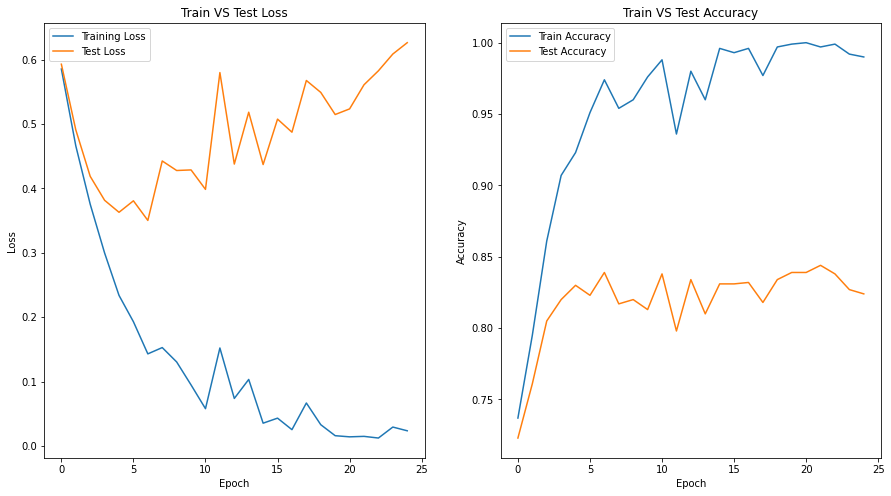

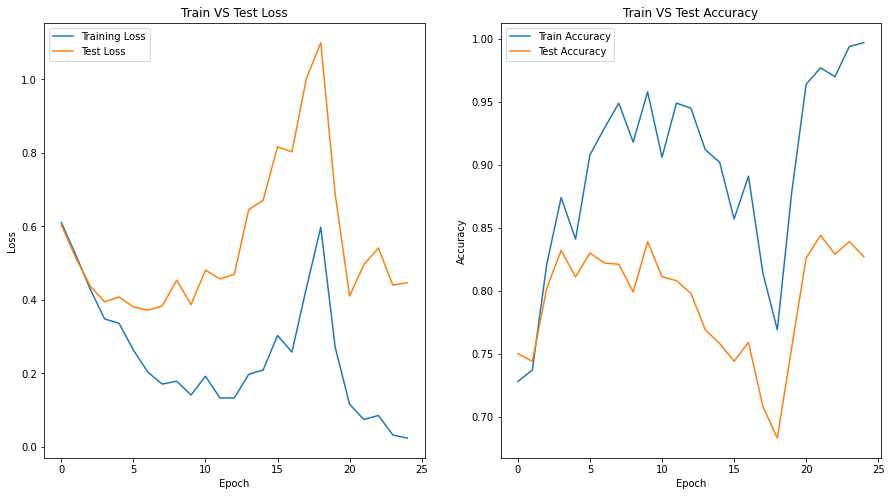

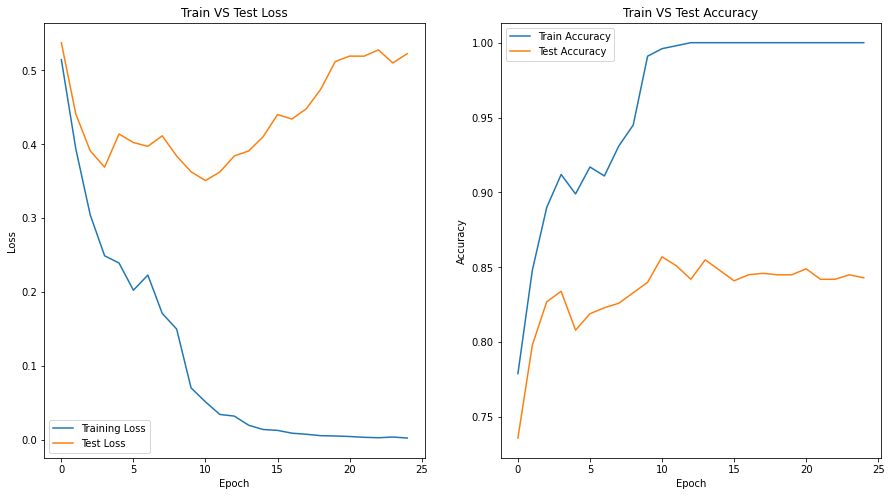

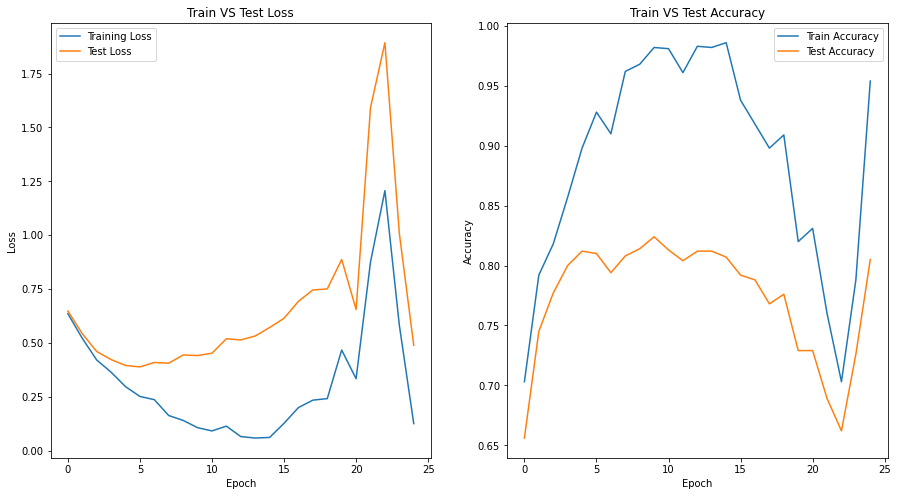

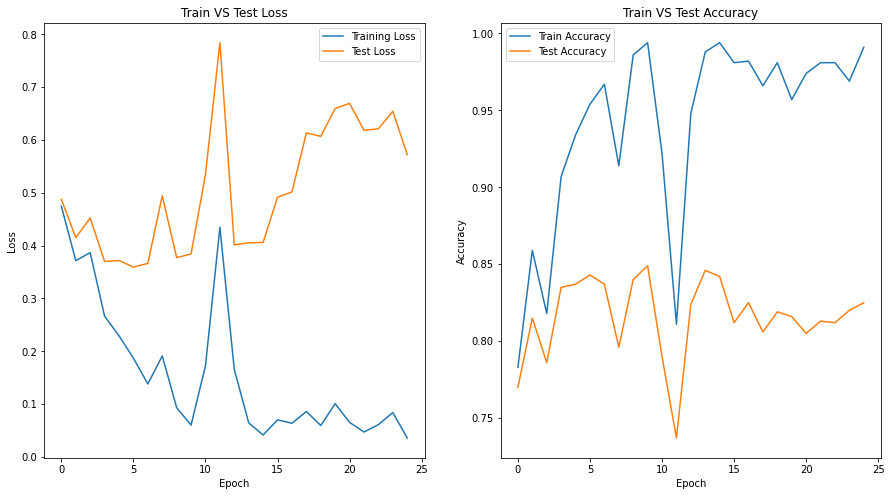

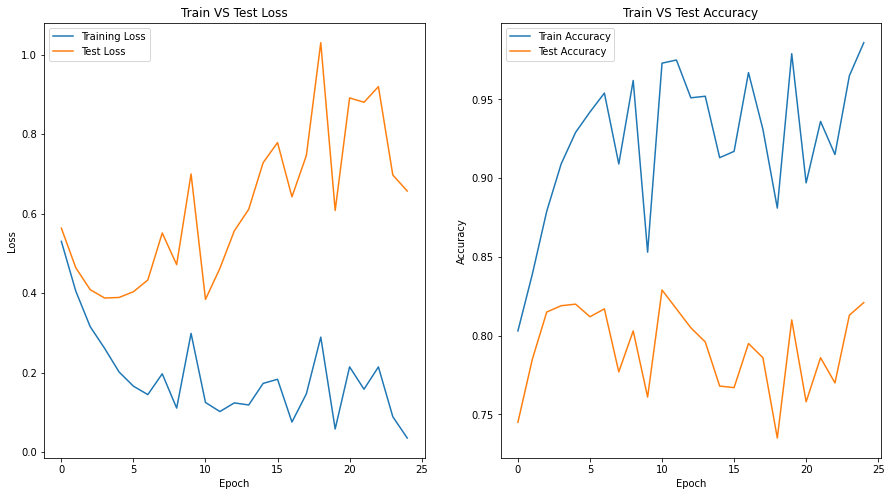

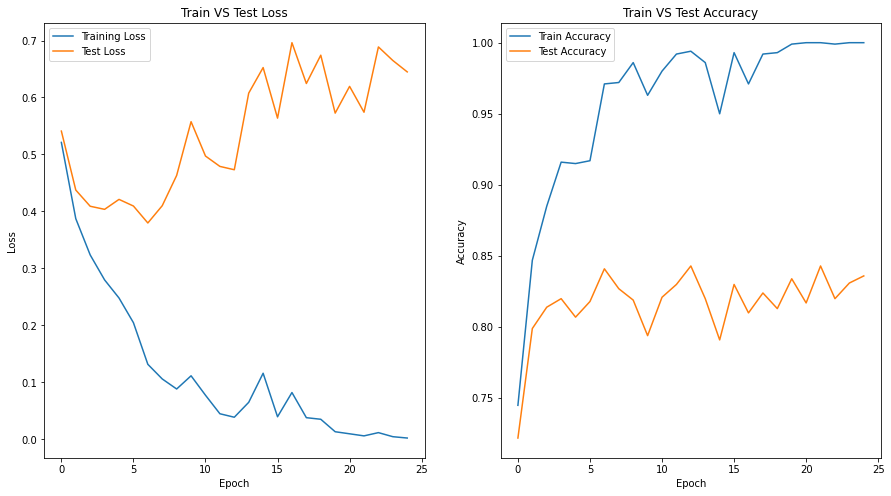

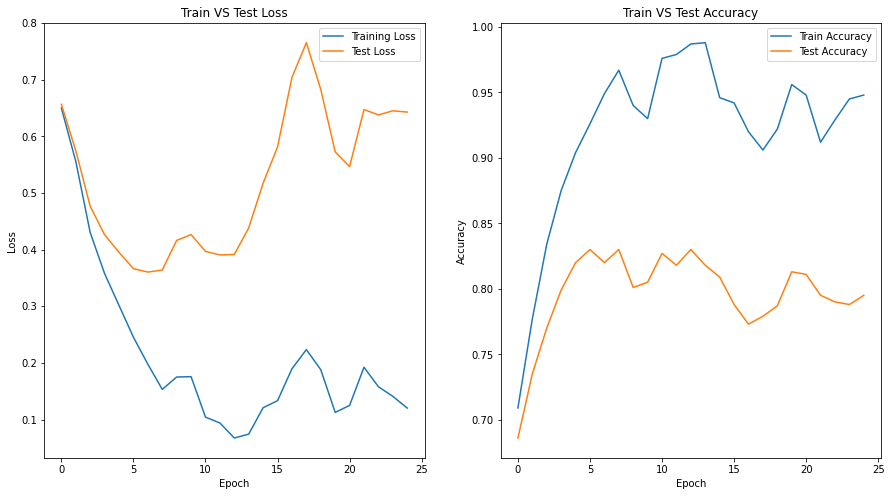

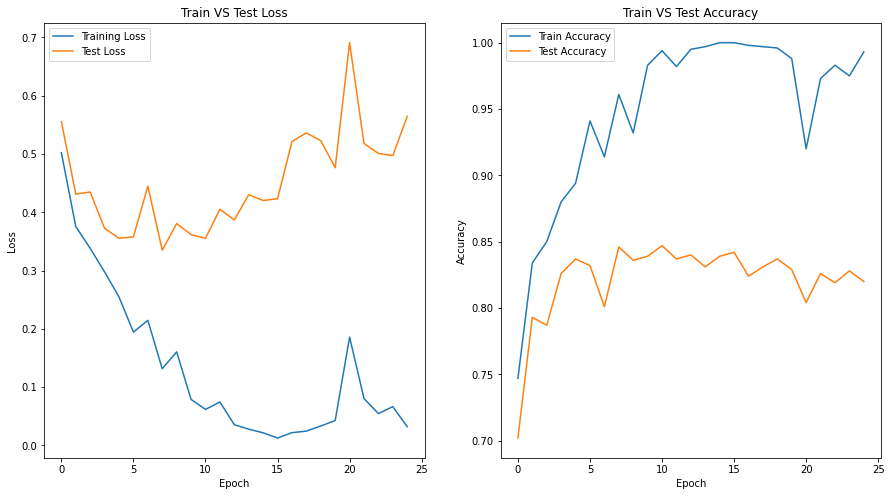

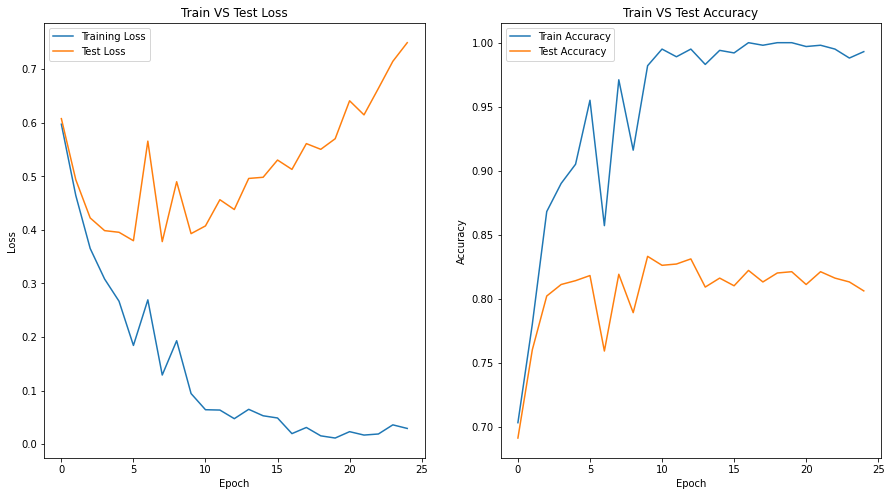

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing()
    # train the model
    my_model.trainer(train_input, train_target,test_input, test_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [12]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error: ',np.mean(train_errors))
print('The mean of test error: ',np.mean(test_errors))

The standard deviation of train error: 0.01764538994092653
The standard deviation of test error: 0.013862178130758969
The mean of train error:  0.01480000615119934
The mean of test error:  0.17979999780654907


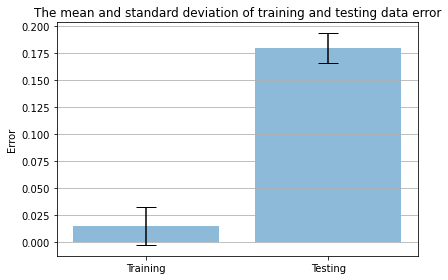

In [13]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors), np.mean(test_errors)]
stds = [np.std(train_errors), np.std(test_errors)]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data error')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()